In [1]:
from cv2 import resize
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.colors as colors

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle

from blusky.transforms.transform_factories_2d import vanilla_scattering_transform

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [3]:
facies_colors = ['#33fffc', '#F9A602', '#50C878', '#FF0800', ]
cmap_facies = colors.ListedColormap(facies_colors, 'indexed')
# no label
cmap_facies.set_bad(alpha = 0.0)

### Load Annotated Data
This data includes sequence labels and seismic data in numpy format.
There is two data sets "InterpretedSequences.npz" which is for training, 
the other "HoldoutLine.npz" is held back to validate the model.

In [4]:
filename = "InterpretedSequences.npz"
data = np.load(filename, allow_pickle=True)
inline = data['CVG_PSTM13_PGS_0535_full_pos_incAIpos Inline 1450']
il_labels = data['Labels Inline 1450']
# labels == 0 is "no-label"
il_masked_labels = np.ma.masked_where(il_labels < 1, il_labels)

xline = data['CVG_PSTM13_PGS_0535_full_pos_incAIpos Crossline 1464']
xl_labels = data['Labels Crossline 1464']
xl_masked_labels = np.ma.masked_where(xl_labels < 1, xl_labels)

In [5]:
filename = "HoldoutLine.npz"
data = np.load(filename, allow_pickle=True)
holdout_line = data['CVG_PSTM13_PGS_0535_full_pos_incAIpos Inline 1550']
holdout_labels = data['Labels Inline 1550']
holdout_masked_labels = np.ma.masked_where(holdout_labels < 1, holdout_labels)

### Make sure everything is lining up.

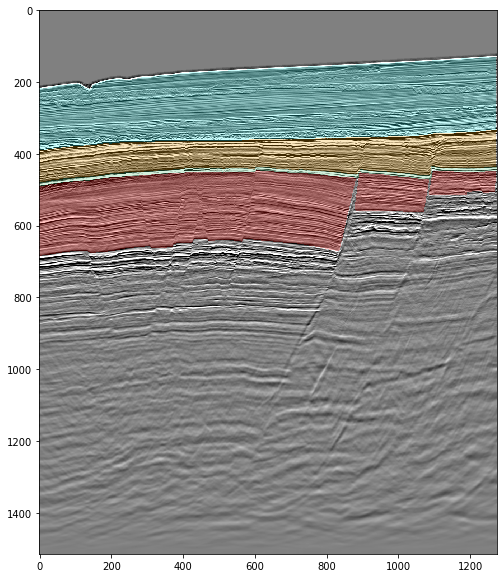

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(inline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
plt.imshow(il_masked_labels, cmap=cmap_facies, alpha=0.25)
plt.show()

### Resize to a power of 2.
The Scattering transform works best where the image size is a power of 2.

In [7]:
il_original_size = inline.shape
_inline = resize(inline, (1024, 1024))
xl_original_size = xline.shape
_xline = resize(xline, (1024, 1024))
holdout_original_size = holdout_line.shape
_holdout = resize(holdout_line, (1024, 1024))

# "Blusky" is a convolutional network that expects multi-channel data:
batch = np.expand_dims(np.array([_inline, _xline, _holdout]), axis=-1)
print (batch.shape)

(3, 1024, 1024, 1)


### Blusk implements the "Mallat Scattering Transform"
https://github.com/enthought/blusky

In [8]:
nang = 4
model, _ = vanilla_scattering_transform(
        3,
        batch.shape[1:],
        1.0,
        num_angles=nang,
        overlap_log_2=3,
        order=2,
        oversampling=3,
        do_father=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 1056, 1056, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 1056, 1056, 4 200         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_2 (DepthwiseCo (None, 1056, 1056, 4 200         reflection_padding2d_1[0][0]     
____________________________________________________________________________________________

In [9]:
# Most of the cost here is compiling the network
result = model.predict(batch)

def resize_result(result, original_size, line=0):
    resized = []
    for i in range(result.shape[-1]):
        resized.append(resize(result[line,:,:,i], original_size))
    return np.array(resized)
# [::-1] - that old chestnut
iline_features = np.vstack([resize_result(i, il_original_size[::-1], 0) for i in result])
xline_features = np.vstack([resize_result(i, xl_original_size[::-1], 1) for i in result])
holdout_features = np.vstack([resize_result(i, holdout_original_size[::-1], 2) for i in result])

### Visualize on of the features

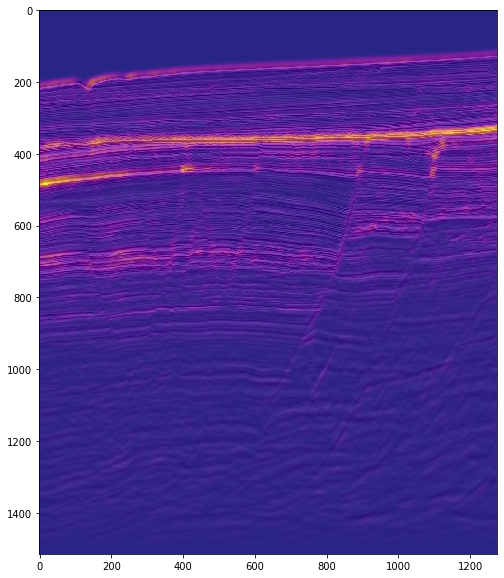

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(inline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
plt.imshow(iline_features[0,:,:], cmap='plasma', alpha=0.75)
plt.show()

### Re-sample the data to address the class imbalance 
There are other strategies, like using class weights to do this.

In [11]:

def sample_by_labels(labels, features, num_samples, sample_labels=[0,1,2,3,4]):
    """ There's large class imbalance, compare the Muderong to others. 
        Normalize the populations in the training data."""
    
    X = []
    y = []
    for target_label in sample_labels:
        indx = np.where(labels==target_label)
        
        rnd = np.random.choice(len(indx[0]), num_samples)
        X.append(features[:,indx[0][rnd], indx[1][rnd]])
        y.append(np.ones(num_samples) * target_label)
        
    #
    X = np.hstack(X)
    y = np.hstack(y)
    
    # Randomize so we can train/test split from this 
    X,y = shuffle(X.T,y)
    
    return X,y

# Sample data and create train/test split (20,000 samples)
il_X, il_y = sample_by_labels(il_labels, iline_features, 10000)
xl_X, xl_y = sample_by_labels(xl_labels, xline_features, 10000)

# combine inline/xline data
X = np.vstack([il_X, xl_X])
y = np.hstack([il_y, xl_y])
X,y = shuffle(X,y)

# this is already randomized 80:20 split
N = int(len(y) * 0.8)
Xtrain, Xtest = X[:N,:], X[N:,:]
ytrain, ytest = y[:N], y[N:]

### Fit the classifier

In [12]:
scaler = RobustScaler()
scaler.fit(Xtrain)

test_scaler = RobustScaler()
test_scaler.fit(Xtest)

rf = RandomForestClassifier()
rf.fit(scaler.transform(Xtrain), ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Validate based on train/test split (biased)

In [13]:
y_pred = rf.predict(test_scaler.transform(Xtest))

# I am intensely skeptical of this:
print (classification_report(ytest, y_pred, 
                target_names=["Junk Class", "Overburden", "Gearle", "Muderong", "Barrow"]))

              precision    recall  f1-score   support

  Junk Class       1.00      0.92      0.96      4019
  Overburden       0.98      0.98      0.98      3922
      Gearle       0.97      0.98      0.97      4063
    Muderong       0.97      1.00      0.99      4044
      Barrow       0.94      0.98      0.96      3952

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



### Visualize the prediction on line.
For clarity we only show the prediction where we have labeled.

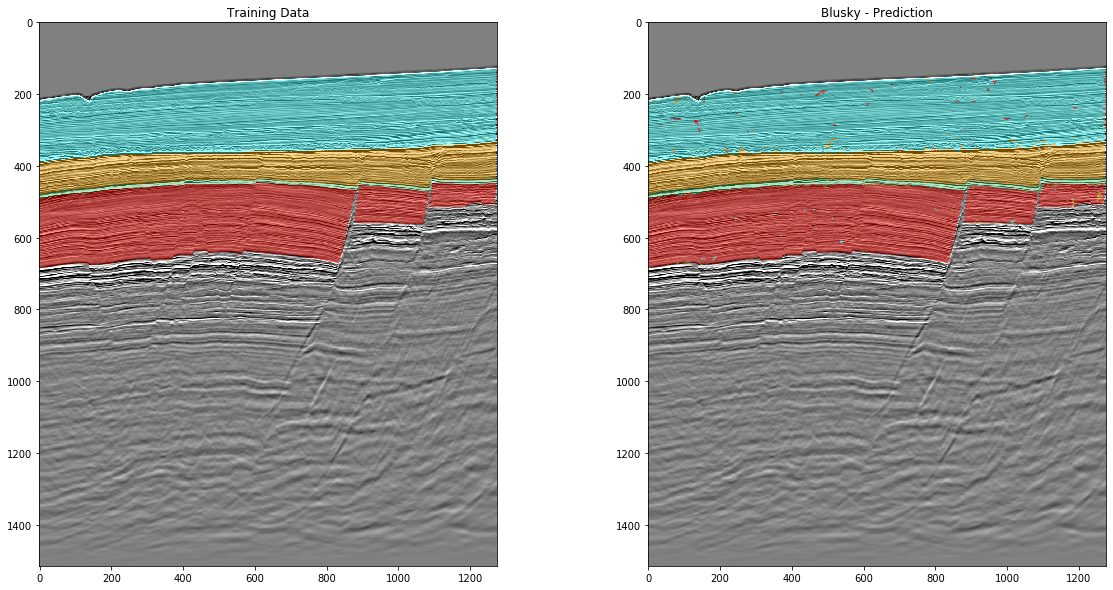

In [14]:
_features = np.vstack([i.ravel() for i in iline_features])
il_facies_pred = rf.predict(scaler.transform(_features.T))
il_facies_pred = np.reshape(il_facies_pred, il_original_size)

# just look at the prediction where we made the labeling
il_facies_pred[il_labels < 1] = 0
# 
il_masked_pred = np.ma.masked_where(il_facies_pred < 1, il_facies_pred)

facies_colors = ['#33fffc', '#F9A602', '#50C878', '#FF0800']
cmap_facies = colors.ListedColormap(facies_colors, 'indexed')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))


ax1.imshow(inline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax1.imshow(il_masked_labels, cmap=cmap_facies, alpha=0.45)
ax1.set_title("Training Data")

ax2.imshow(inline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax2.imshow(il_masked_pred, cmap=cmap_facies, alpha=0.45)
ax2.set_title("Blusky - Prediction")

plt.show()

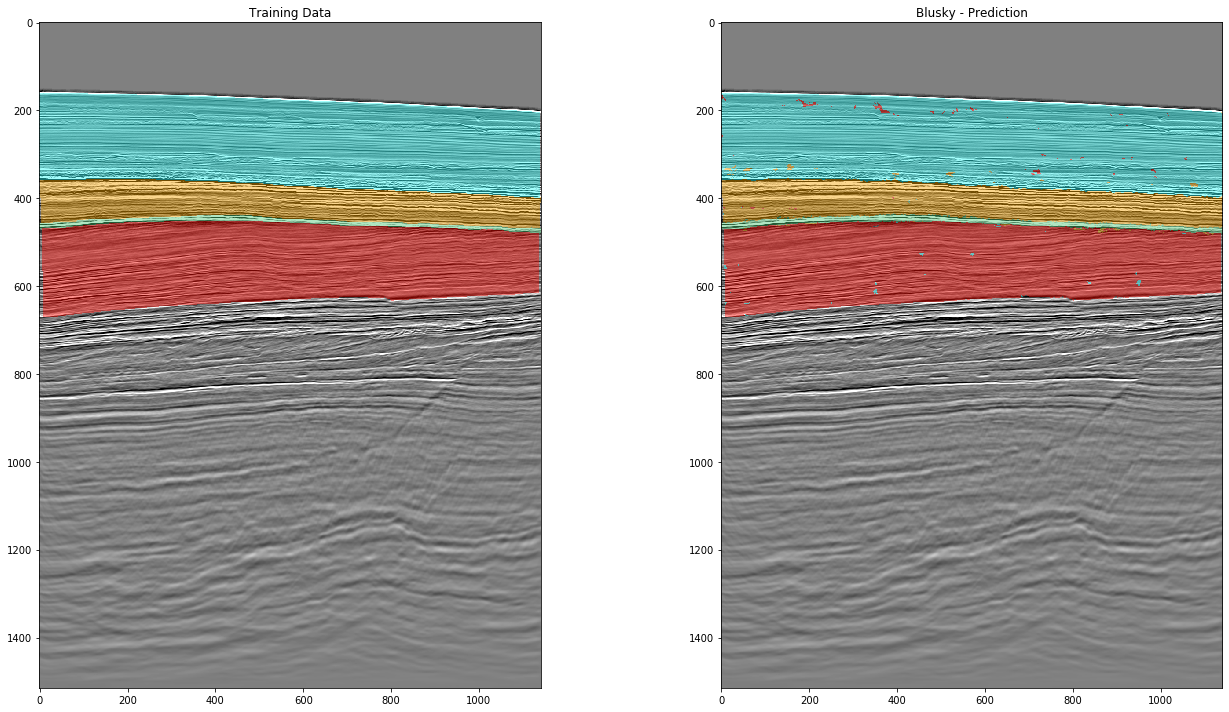

In [15]:
_features = np.vstack([i.ravel() for i in xline_features])
xl_facies_pred = rf.predict(scaler.transform(_features.T))
xl_facies_pred = np.reshape(xl_facies_pred, xl_original_size)

# just look at the prediction where we made the labeling
xl_facies_pred[xl_labels < 1] = 0
xl_masked_pred = np.ma.masked_where(xl_facies_pred < 1, xl_facies_pred)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(xline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax1.imshow(xl_masked_labels, cmap=cmap_facies, alpha=0.45)
ax1.set_title("Training Data")

ax2.imshow(xline, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax2.imshow(xl_masked_pred, cmap=cmap_facies, alpha=0.45)
ax2.set_title("Blusky - Prediction")

plt.tight_layout()

plt.show()

### Evaluate the prediction on a hold-out line

In [16]:
from sklearn.metrics import classification_report

_features = np.vstack([i.ravel() for i in holdout_features])
holdout_facies_pred = rf.predict(scaler.transform(_features.T))
holdout_facies_pred = np.reshape(holdout_facies_pred, holdout_original_size)

# I am intensely skeptical of this:
print (classification_report(holdout_labels.ravel(), holdout_facies_pred.ravel(), 
                target_names=["Junk Class", "Overburden", "Gearle", "Muderong", "Barrow"]))

              precision    recall  f1-score   support

  Junk Class       0.99      0.91      0.95   1360328
  Overburden       0.92      0.83      0.88    253359
      Gearle       0.54      0.92      0.68    102318
    Muderong       0.48      0.34      0.40     13890
      Barrow       0.64      0.83      0.72    203245

    accuracy                           0.89   1933140
   macro avg       0.71      0.77      0.73   1933140
weighted avg       0.92      0.89      0.90   1933140



### Visualize the prediction on line.
For clarity we only show the prediction where we have labeled.

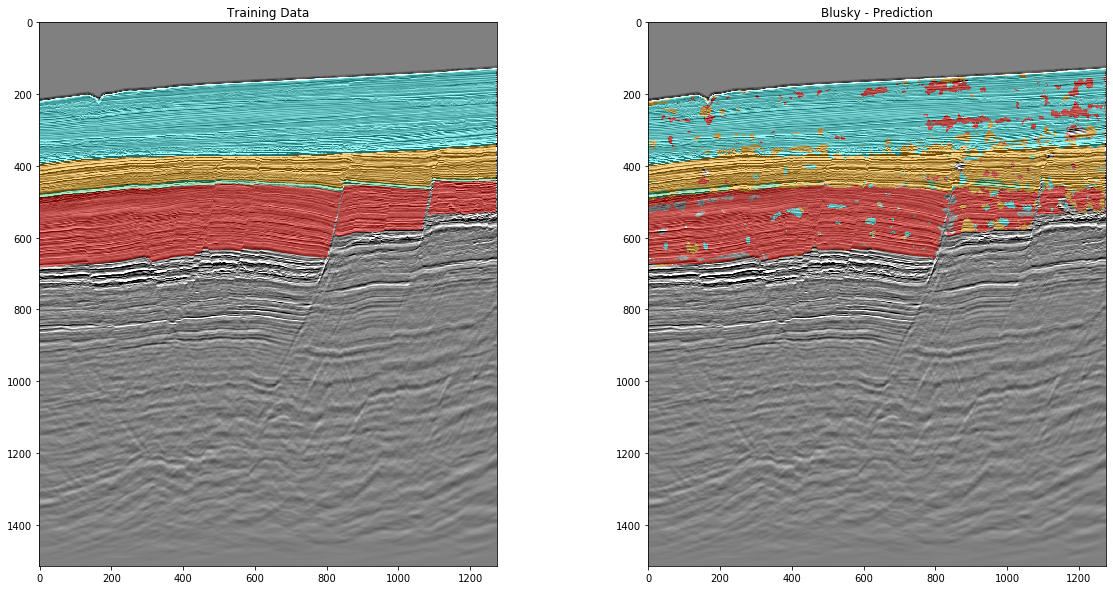

In [17]:
# just look at the prediction where we made the labeling
holdout_facies_pred[holdout_labels < 1] = 0
# 
holdout_masked_pred = np.ma.masked_where(holdout_facies_pred < 1, holdout_facies_pred)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(holdout_line, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax1.imshow(holdout_masked_labels, cmap=cmap_facies, alpha=0.45)
ax1.set_title("Training Data")

ax2.imshow(holdout_line, cmap='gray', vmin=-2*np.std(inline), vmax=2*np.std(inline))
ax2.imshow(holdout_masked_pred, cmap=cmap_facies, alpha=0.45)
ax2.set_title("Blusky - Prediction")

plt.show()